In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from preprocessing import *

In [2]:
train_df, valid_df, test_df = get_datasets()
print("Number of samples: {} for training, {} for validation, {} for testing.".format(
    len(train_df), len(valid_df), len(test_df)))

Number of samples: 1021 for training, 439 for validation, 1459 for testing.


In [3]:
train_df = preprocess_dataset(train_df)
valid_df = preprocess_dataset(valid_df)
test_df = preprocess_dataset(test_df, is_testing=True)

In [4]:
train_df.to_csv(PROCESSED_DATA_PATH+'train_processed.csv')
valid_df.to_csv(PROCESSED_DATA_PATH+'valid_processed.csv')
test_df.to_csv(PROCESSED_DATA_PATH+'test_processed.csv')

In [5]:
train_df, valid_df, test_df = get_processed_datasets()
train_df, valid_df, test_df = replace_category_with_dummy_datasets(train_df, valid_df, test_df, to_drop=False)
train_df.to_csv(PROCESSED_DATA_PATH+'train_processed_with_dummies.csv')
valid_df.to_csv(PROCESSED_DATA_PATH+'valid_processed_with_dummies.csv')
test_df.to_csv(PROCESSED_DATA_PATH+'test_processed_with_dummies.csv')

In [6]:
train_df, valid_df, test_df = get_processed_datasets()
train_df, valid_df, test_df = replace_category_with_dummy_datasets(train_df, valid_df, test_df, to_drop=True)
train_df.to_csv(PROCESSED_DATA_PATH+'train_processed_with_dummies(k-1).csv')
valid_df.to_csv(PROCESSED_DATA_PATH+'valid_processed_with_dummies(k-1).csv')
test_df.to_csv(PROCESSED_DATA_PATH+'test_processed_with_dummies(k-1).csv')

dropped:
CentralAir_N
MSZoning_RL
LotShape_Reg
Neighborhood_NAmes
Foundation_PConc
WasRemodeled_N
Condition1_Norm
BldgType_1Fam
HouseStyle_1Story


In [7]:
import statsmodels.api as sm
y = train_df['SalePrice']
X = train_df.drop(columns='SalePrice').copy()
model = sm.OLS(y, X)

In [8]:
res = model.fit()
print(res.summary())
pd.DataFrame(res.summary().tables[1]).to_csv('../solution/simple_ols_summary.csv')

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              537.3
Date:                Mon, 01 Apr 2024   Prob (F-statistic):                        0.00
Time:                        05:28:53   Log-Likelihood:                         -12055.
No. Observations:                1021   AIC:                                  2.424e+04
Df Residuals:                     955   BIC:                                  2.457e+04
Df Model:                          66                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [9]:
train_predict = res.predict(train_df.drop(columns='SalePrice'))
valid_predict = res.predict(valid_df.drop(columns='SalePrice'))
test_predict = res.predict(test_df)
pd.DataFrame({'Id': test_df.index, 'SalePrice': test_predict}).to_csv('../solution/simple_ols_submit.csv', index=False)

In [10]:
from statsmodels.tools.eval_measures import rmse
rmse(train_df.SalePrice, train_predict, axis=0), rmse(valid_df.SalePrice, valid_predict, axis=0)

(32469.362186921593, 33927.90155373259)

Text(0.5, 1.0, 'Simple OLS with Training data\nTrue vs Predicted Sale Price')

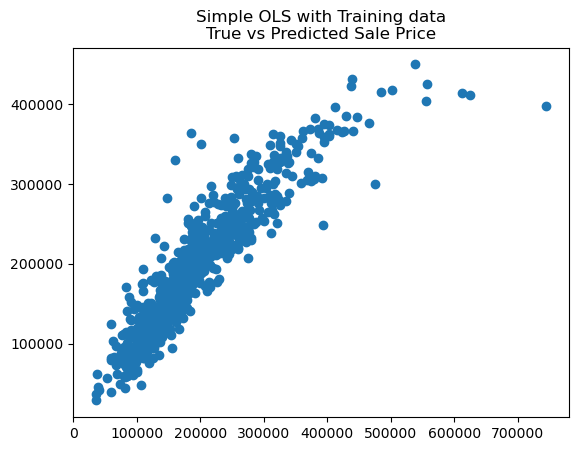

In [11]:
plt.scatter(train_df['SalePrice'], train_predict)
plt.title('Simple OLS with Training data\nTrue vs Predicted Sale Price')

Text(0.5, 1.0, 'Simple OLS with Validation data\nTrue vs Predicted Sale Price')

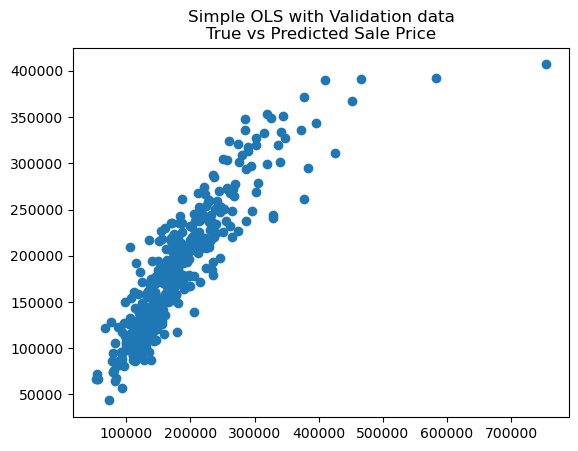

In [12]:
plt.scatter(valid_df['SalePrice'], valid_predict)
plt.title('Simple OLS with Validation data\nTrue vs Predicted Sale Price')

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
vif_data.sort_values('VIF').tail(10)

,feature,VIF
56,LotArea,14.242883
65,AgeWhenSold,15.827081
0,CentralAir_Y,17.164234
62,TotalBath,21.116632
57,TotalBsmtSF,29.842780
59,BedroomAbvGr,34.766977
64,GarageArea,36.149818
63,GarageCars,40.502687
58,GrLivArea,86.377734
60,TotRmsAbvGrd,94.757152


In [14]:
df = get_processed_datasets()[0]
numeric_features, category_features = get_features(df)

In [15]:
from sklearn.decomposition import PCA
Z = X[get_features(get_processed_datasets()[0])[0]]
Z = (Z-Z.mean()) / Z.std()
pca = PCA(n_components=10)
pca.fit(Z)
print(pca.explained_variance_ratio_)

[0.40867854 0.16187331 0.09594475 0.08884467 0.06576186 0.05465485
 0.04787481 0.03336002 0.02251922 0.01120196]


Text(0.5, 1.0, 'Variance% explained for first 10 PCA from numerical features')

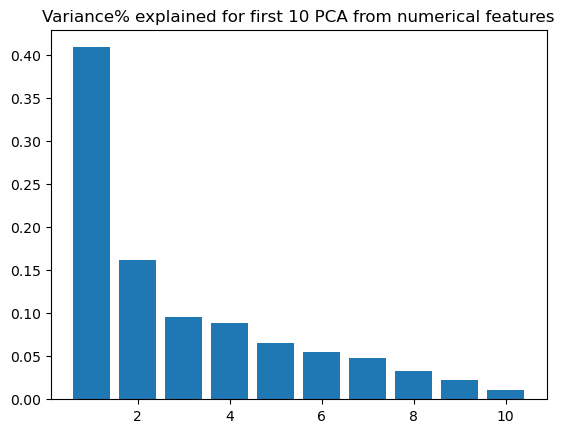

In [16]:
plt.bar(range(1,11), pca.explained_variance_ratio_[:10])
plt.title('Variance% explained for first 10 PCA from numerical features')

<AxesSubplot:ylabel='feature'>

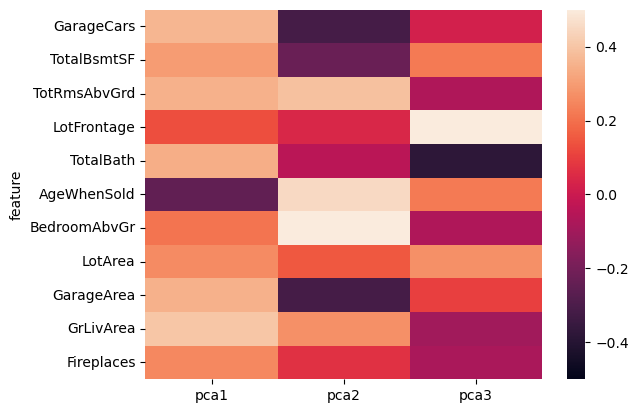

In [17]:
import seaborn as sns
weight_to_pca = pd.DataFrame({'feature': Z.columns, 'pca1': pca.components_[0], 'pca2': pca.components_[1], 'pca3': pca.components_[2]}).round(2)
sns.heatmap(weight_to_pca.set_index('feature'),vmin=-0.5, vmax=0.5)